In [116]:
import datetime
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
#plt.style.usd('fivethirtyeight')

In [117]:
df=web.DataReader('AMZN', data_source='yahoo',start='2010-01-01')

In [118]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,137.279999,134.520004,137.089996,134.520004,4523000,134.520004
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000


In [119]:
df.shape

(2616, 6)

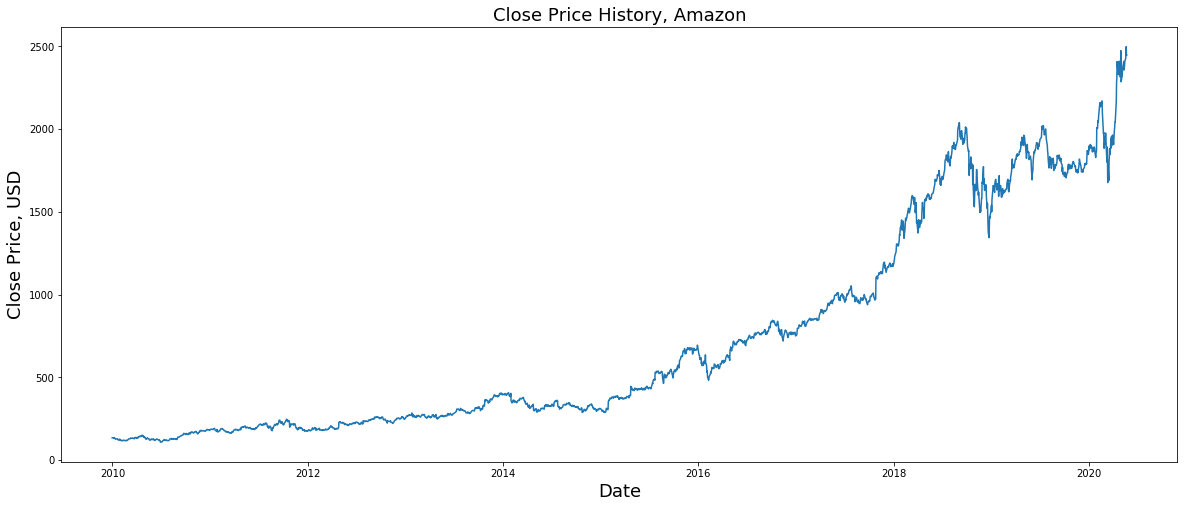

In [120]:
#Visualize closing price history, 2010 to 2020
plt.figure(figsize=(20,8))
plt.title('Close Price History, Amazon',fontsize=18)
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price, USD',fontsize=18)
plt.show()

In [121]:
#Create dataframe based on Close column
data=df.filter(['Close'])
#Covert to numpy array
dataset=data.values

In [122]:
#Scale Data to 0-1 (inclusive)
scaler = MinMaxScaler(feature_range=(0,1))
data_scale = scaler.fit_transform(dataset)


In [123]:
#Train Test split ratio
#Use a split ration of 0.8
train_length = math.ceil(len(dataset) * 0.8)
test_length = len(dataset)-train_length
print(train_length, test_length, train_length+test_length)
# 2093 523 2616, Train is index 1 to 2093, Test is index 2094 to 2616

2093 523 2616


In [124]:
# set period of prediction to be 60 days. 
p=60

In [125]:
#Create train set
train_data = data_scale[0:train_length,:]
train_data
x_train=[]
y_train=[]

for i in range (p, len(train_data)):
    x_train.append(train_data[i-p:i,0])
    y_train.append(train_data[i,0])
    #X_train contains 80 values, and y_train contains the 81st value
    #to see 2 examples of what is appended
    if i in (p,p+1):
        print(train_data[i-p:i,0],train_data[i,0],i)
        print()



[0.01084405 0.01058455 0.01091519 0.00989399 0.0089523  0.01042552
 0.00908204 0.0078432  0.00857981 0.0078432  0.00775531 0.00795202
 0.00718611 0.00753768 0.00536552 0.00489677 0.00454939 0.00591798
 0.00729075 0.00703126 0.00429409 0.0039802  0.00439035 0.00306781
 0.00367467 0.0034403  0.00394253 0.00366211 0.00480469 0.00462473
 0.00373326 0.00322266 0.00396345 0.00372908 0.00393416 0.00361189
 0.00464984 0.00401368 0.00409738 0.00666714 0.00708148 0.00723215
 0.00833706 0.00849611 0.00899834 0.00845844 0.00916575 0.01045063
 0.00971402 0.00942524 0.00970146 0.00951313 0.01010743 0.00909879
 0.00914901 0.00864259 0.00813198 0.01093193 0.01107005 0.01109516] 0.011706211328597907 60

[0.01058455 0.01091519 0.00989399 0.0089523  0.01042552 0.00908204
 0.0078432  0.00857981 0.0078432  0.00775531 0.00795202 0.00718611
 0.00753768 0.00536552 0.00489677 0.00454939 0.00591798 0.00729075
 0.00703126 0.00429409 0.0039802  0.00439035 0.00306781 0.00367467
 0.0034403  0.00394253 0.00366211 0.

In [126]:
#Convert x_train and y_train to numpy arrays, for LSTM model
x_train,y_train=np.array(x_train) , np.array(y_train)


In [127]:
x_train.shape
#Current shape is 2d (2013,80). LSTM model expects 3d
#Reshape data, to take in format of (2013,80,1), with 1 feature of close price
#x_train = np.reshape(2013,80,1) 
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

In [128]:
#Build LSTM Model
model = Sequential()
#50 neurons, True return_sequence because we will use another layer,input_shape= number of time steps and features (80,1)
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
#other layers
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#complete neural network architecture

In [129]:
#Compile LSTM model
model.compile(optimizer='adam',loss='mean_squared_error')

In [130]:
model.fit(x_train,y_train,batch_size=2, epochs=2)

Epoch 1/1
2033/2033 [==============================] - 57s 28ms/step - loss: 4.4959e-04


In [131]:
#Create Test set, Test is index 2094 to 2616
test_data = data_scale[train_length-p:,:]
len(test_data)
x_test=[]
y_test=dataset[train_length:,:]
for i in range(p,len(test_data)):
    x_test.append(test_data[i-p:i,0])

In [132]:
#Convert to numpy array, for use in LSTM
x_test = np.array(x_test)
#Reshape to 3d (Similar to previous train set)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [133]:
#Prediction
predictions = model.predict(x_test)
#Inverse Transform, unscaling the values
predictions = scaler.inverse_transform(predictions)

In [134]:
#Evaluate Model, using RMSE
rmse= np.sqrt(np.mean(((predictions-y_test)**2)))
rmse

105.93114881995864

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


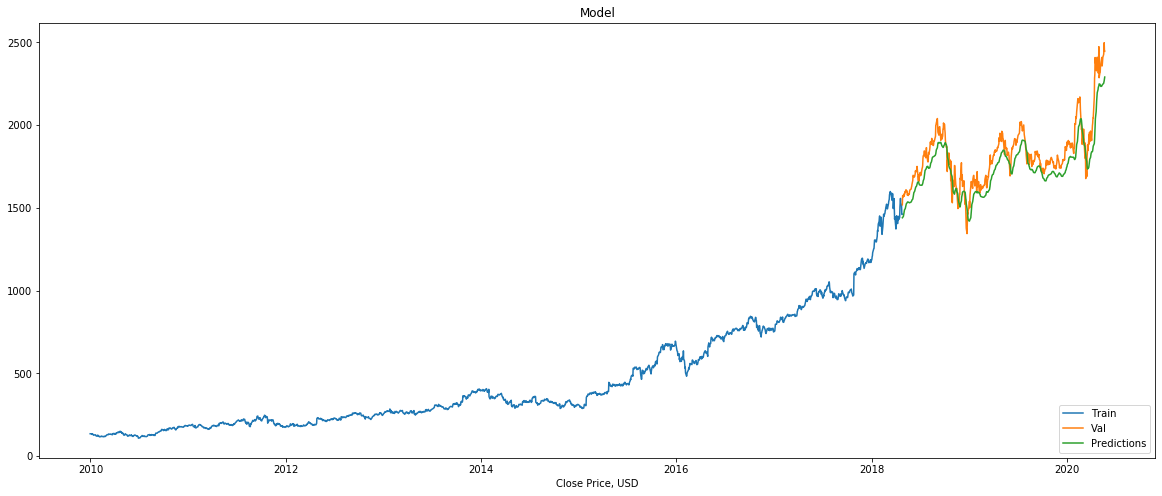

In [135]:
#Plot data
train=data[:train_length]
valid = data[train_length:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(20,8))
plt.title('Model')
plt.xlabel('Date')
plt.xlabel('Close Price, USD')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')

In [136]:
#Show actual vs predicted price
valid

,Close,Predictions
Date,,
2018-04-26,1517.959961,1439.675171
2018-04-27,1572.619995,1441.415894
2018-04-30,1566.130005,1449.085571
2018-05-01,1582.260010,1458.543457
2018-05-02,1569.680054,1469.526123
...,...,...
2020-05-18,2426.260010,2252.145752
2020-05-19,2449.330078,2258.749268
2020-05-20,2497.939941,2267.544922


In [137]:
#Predict Closing price for Amazon
amazon_quote = web.DataReader('AMZN',data_source='yahoo',start= '2012-06-01', end = '2020-05-22')
new_df = amazon_quote.filter(['Close'])
#Get last p days, convert to array
last_p_days = new_df[-p:].values
last_p_days_scaled = scaler.transform(last_p_days)
#create empty list and append past p days
xtest = []
xtest.append(last_p_days_scaled)
#Convert to numpy array
xtest = np.array(xtest)
#Reshape to 3d
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
#Get Predicted scaled price
pred_price = model.predict(xtest)
#undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[2297.4758]]


In [138]:
#Actual price
amazon_actual = web.DataReader('AMZN',data_source='yahoo',start= '2020-05-22')
actual = amazon_actual.loc['2020-05-22','Close']
print(actual)


2444.820068359375
